## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub
import tensorflow_datasets as tfds

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import datetime
import os
import random
import itertools


In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
RANDOM_SEED = 42

In [4]:
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

## Helper Functions

In [5]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [6]:
def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [7]:
def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.

  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"

  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [8]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [9]:
def compare_history(original_history, new_history, initial_epochs=3):
    """
    Compares two TensorFlow model History objects.
    
    Args:
      original_history: History object from original model (before new_history)
      new_history: History object from continued model training (after original_history)
      initial_epochs: Number of epochs in original_history (new_history plot starts from here) 
    """
    
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()
  

### Apple M1/M2 config check

**Note:** Mixed precision training will only work on Tesla T4

In [ ]:
print(tf.__version__)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("PHYSICAL DEVICES : ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2.11.1
PHYSICAL DEVICES :  1


### Check available datasets

In [3]:
all_datasets = tfds.list_builders()
print('food101' in all_datasets)

True


### Pull food101 dataset

In [10]:
# Load in the data (takes about 5-6 minutes in Google Colab)

(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)


In [ ]:
ds_info

In [26]:
n_classes = ds_info.features['label'].num_classes

## Explore!

In [20]:
# Get class names
class_names = ds_info.features["label"].names
n_classes = len(class_names)
class_names[:15]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake']

In [ ]:
# Pull first image
sample = train_data.take(1)
sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
for image, label in sample:
    print(f"""
    Image shape: {image.shape}
    Image dtype: {image.dtype}
    Target class from Food101 (tensor form): {label}
    Class name (str form): {class_names[label.numpy()]}
    """)


    Image shape: (384, 512, 3)
    Image dtype: <dtype: 'uint8'>
    Target class from Food101 (tensor form): 56
    Class name (str form): huevos_rancheros
    


2023-05-16 15:08:46.066097: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [ ]:
image
# will need to reshape

<tf.Tensor: shape=(384, 512, 3), dtype=uint8, numpy=
array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [144,  81, 102],
        [142,  78, 102],
        [139,  75,  99]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [159,  96, 115],
        [154,  89, 111],
        [146,  83, 104]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [162,  98, 114],
        [162,  95, 113],
        [157,  93, 110]],

       ...,

       [[ 75,  32,  16],
        [ 77,  34,  17],
        [ 78,  35,  19],
        ...,
        [ 99,  31,  20],
        [104,  32,  20],
        [106,  34,  20]],

       [[ 81,  34,  18],
        [ 81,  34,  16],
        [ 82,  35,  19],
        ...,
        [102,  33,  26],
        [104,  36,  27],
        [109,  39,  31]],

       [[ 79,  30,  13],
        [ 80,  31,  14],
        [ 81,  32,  15],
        ...,
        [113,  46,  4

In [ ]:
label

<tf.Tensor: shape=(), dtype=int64, numpy=56>

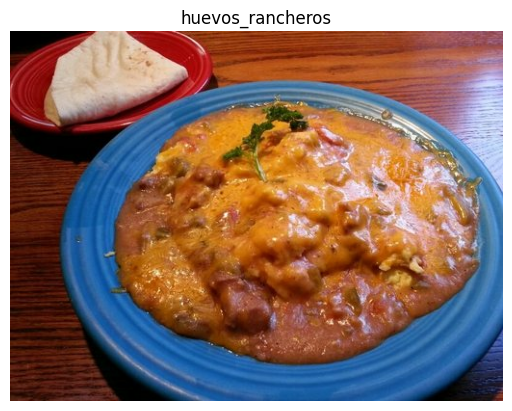

In [ ]:
plt.imshow(image)
plt.title(class_names[label.numpy()]) # add title to image by indexing on class_names list
plt.axis(False);

In [12]:
def preprocess_image(image, label, img_shape=224):
    """
    Converts image datatype from 'uint8' -> 'float32' and reshapes image to
    [img_shape, img_shape, color_channels]
    """
    image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
    return tf.cast(image, tf.float32), label # return (float32_image, label) tuple


In [ ]:
preprocessed_image = preprocess_image(image, label)[0]

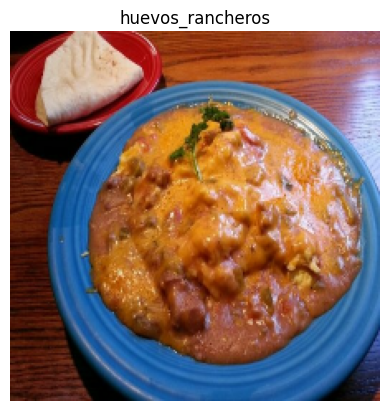

In [ ]:
plt.imshow(preprocessed_image/255.)
plt.title(class_names[label])
plt.axis(False);

In [13]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

### Model prep
#### Callbacks

In [14]:
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

# Create learning rate reduction callback
reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print when learning rate goes down 
                                                 min_lr=1e-7)

#### Enable mixed precision training

In [15]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision 

In [16]:
mixed_precision.global_policy() # <Policy "mixed_float16">

<Policy "mixed_float16">

#### Set constants

In [17]:
model_configuration = {'INPUT_SHAPE': (224, 224, 3),
                       'BATCH_SIZE': 32,
                       'EPOCHS': 3}
model_directory = '/content/gdrive/MyDrive/whatamieating?/models'

## Feature Extraction Model 

### efnb0_1: EfficientNetV2B0 (Frozen) 

No augmentation was performed as there is low risk of overfitting. Dataset is large and diverse.

In [18]:
def build_fit_efnb0_1(train_data, test_data, model_configuration):
    base_model = tf.keras.applications.EfficientNetV2B0(include_top=False)
    base_model.trainable = False
    
    inputs = layers.Input(shape=model_configuration['INPUT_SHAPE'], name='input_layer')
    # x = layers.Rescaling(1./255)(x)
    x = base_model(inputs, training=False) # set base_model to inference mode
    x = layers.GlobalAveragePooling2D(name='pooling_layer')(x)
    x = layers.Dense(n_classes)(x)
    
    outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
    model = tf.keras.Model(inputs, outputs)
    
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=['accuracy'])
    
    print(model.summary())
    
    print('Check for mixed precision in model\n')
    for layer in model.layers:
        print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) 
    
    print('\nCheck first 10 layers of base model for mixed precision\n')
    for layer in model.layers[1].layers[:10]: # only check the first 20 layers to save output space
        print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)
    
    tf.get_logger().setLevel('ERROR') # Only show errors
    
    history = model.fit(train_data,
                        epochs=model_configuration['EPOCHS'],
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=int(0.15 * len(test_data)),
                        callbacks=[create_tensorboard_callback("training_logs", 
                                                               "efnb0_1"),
                                                               model_checkpoint])
    model.save(os.path.join(model_directory, 'efnb0_1'))
    return history

In [27]:
efnb0_1_history = build_fit_efnb0_1(train_data, test_data, model_configuration)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                             

2368/2368 [==============================] - 263s 102ms/step - loss: 1.7448 - accuracy: 0.5773 - val_loss: 1.1461 - val_accuracy: 0.6968
Epoch 2/3
2366/2368 [============================>.] - ETA: 0s - loss: 1.2119 - accuracy: 0.6882

2368/2368 [==============================] - 242s 101ms/step - loss: 1.2120 - accuracy: 0.6882 - val_loss: 1.0429 - val_accuracy: 0.7240
Epoch 3/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.0643 - accuracy: 0.7214

2368/2368 [==============================] - 238s 99ms/step - loss: 1.0644 - accuracy: 0.7214 - val_loss: 0.9795 - val_accuracy: 0.7386


In [47]:
efnb0_1_model = tf.keras.models.load_model(os.path.join(model_directory, 'efnb0_1'))
efnb0_1_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense_2 (Dense)             (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                           

In [24]:
efnb0_1_results = efnb0_1_model.evaluate(test_data)

790/790 [==============================] - 56s 67ms/step - loss: 1.0025 - accuracy: 0.7244


### efnb0_2: Fine tuning on efnb0_1 (All layers unfrozen, Extra callbacks) 

All layers were unfrozen as the dataset is large and less likely to overfit. Might be wrong though 
¯\\_(ツ)_/¯

In [28]:
efnb0_2_model = tf.keras.models.load_model(os.path.join(model_directory, 'efnb0_1'))

#### Unfreeze all layers

In [29]:
for layer in efnb0_2_model.layers:
    layer.trainable = True # all layers
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) 
    # ensure mixed precision dtype_policy ("mixed_float16")


input_layer True float32 <Policy "float32">
efficientnetv2-b0 True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


#### Check dtype policy (need mixed precision)

In [17]:
for layer in efnb0_2_model.layers[1].layers[:20]:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # <Policy "mixed_float16">

input_4 True float32 <Policy "float32">
rescaling_5 True float32 <Policy "mixed_float16">
normalization_3 True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block1a_project_activation True float32 <Policy "mixed_float16">
block2a_expand_conv True float32 <Policy "mixed_float16">
block2a_expand_bn True float32 <Policy "mixed_float16">
block2a_expand_activation True float32 <Policy "mixed_float16">
block2a_project_conv True float32 <Policy "mixed_float16">
block2a_project_bn True float32 <Policy "mixed_float16">
block2b_expand_conv True float32 <Policy "mixed_float16">
block2b_expand_bn True float32 <Policy "mixed_float16">
block2b_expand_activation True float32 <Policy "mixed_float16">
block2b_project_conv True float32 <Policy "mixed_float1

In [30]:
def fine_tune_efnb0_2(model, train_data):
  model.compile(loss="sparse_categorical_crossentropy", # NOT one-hot!!!
                        optimizer=tf.keras.optimizers.Adam(0.0001), # lowered by 10x
                        metrics=["accuracy"])

  history = model.fit(train_data,
                      epochs=100, # fine-tune for a max of 100 epochs
                      steps_per_epoch=len(train_data),
                      validation_data=test_data,
                      validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                      callbacks=[create_tensorboard_callback("training_logs", "efnb0_2"), # track the model training logs
                      model_checkpoint, # save only the best model during training
                      early_stopping, # stop model after X epochs of no improvements
                      reduce_learning_rate]) # reduce the learning rate after X epochs of no improvements
  model.save(os.path.join(model_directory, 'efnb0_2'))
  return history

In [31]:
efnb0_2_history = fine_tune_efnb0_2(efnb0_2_model, train_data)

Saving TensorBoard log files to: training_logs/efnb0_2/20230516-183848
Epoch 1/100
2368/2368 [==============================] - ETA: 0s - loss: 0.8704 - accuracy: 0.7669

2368/2368 [==============================] - 453s 163ms/step - loss: 0.8704 - accuracy: 0.7669 - val_loss: 0.7229 - val_accuracy: 0.8011 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 327s 136ms/step - loss: 0.5149 - accuracy: 0.8560 - val_loss: 0.7269 - val_accuracy: 0.8035 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - ETA: 0s - loss: 0.2656 - accuracy: 0.9239
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 334s 140ms/step - loss: 0.2656 - accuracy: 0.9239 - val_loss: 0.7978 - val_accuracy: 0.7998 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - 331s 139ms/step - loss: 0.0553 - accuracy: 0.9873 - val_loss: 0.9093 - val_accuracy: 0.8149 - lr: 2.0000e-05


## Metrics! Will need sklearn.

In [32]:
final_model = tf.keras.models.load_model(os.path.join(model_directory, 'efnb0_2'))

#### Extract y_labels from test_data

In [33]:
final_loss, final_accuracy = final_model.evaluate(test_data)
pred_probs = final_model.predict(test_data, verbose=1)
pred_classes = pred_probs.argmax(axis=1) # get location of highest probability

790/790 [==============================] - 56s 69ms/step


In [34]:
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) 

# TODO 1.
#### Validate Accuracy - Not accurate because of shuffling :/

In [35]:
sklearn_accuracy = accuracy_score(y_labels, pred_classes)

if np.isclose(final_accuracy, sklearn_accuracy):
  print('Accuracy scores match')
else:
  print('Accuracy score mismatch')


Accuracy score mismatch


#### Compare epoch histories of efnb0_1 and efnb0_2

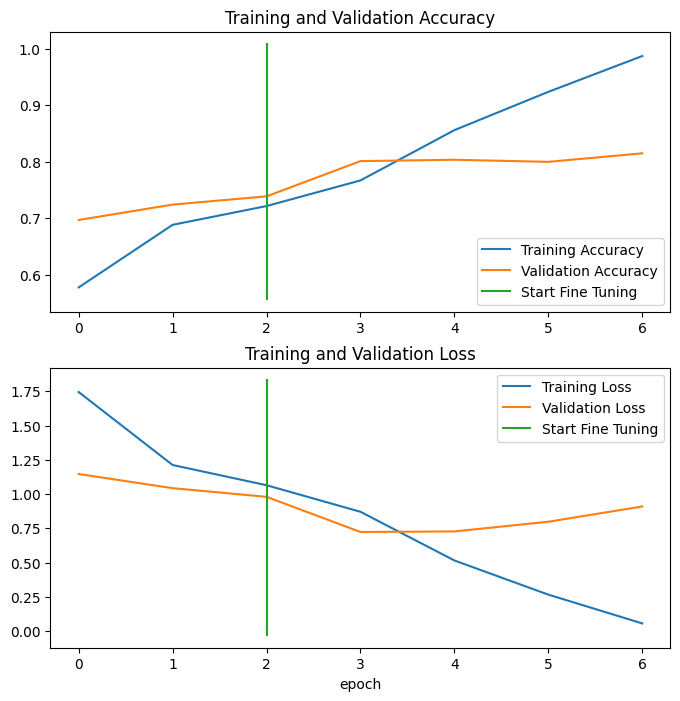

In [38]:
compare_history(original_history=efnb0_1_history, new_history=efnb0_2_history, initial_epochs=3)

**Note: Model starts to overfit after 3 epochs. Oops**